# Building a GPT-like LLM to Generate Text

### Contacts: Cristiano De Nobili
For any questions or doubts you can find my contacts here:
<p align="center">

[<img src="https://img.freepik.com/premium-vector/linkedin-logo_578229-227.jpg?w=1060" width="25">](https://www.linkedin.com/in/cristiano-de-nobili/) [<img src="https://1.bp.blogspot.com/-Rwqcet_SHbk/T8_acMUmlmI/AAAAAAAAGgw/KD_fx__8Q4w/s1600/Twitter+bird.png" width="30">](https://twitter.com/denocris)        

</p>

or here (https://denocris.com).

The goal of this lecture is to build a GPT-2 like LLM architecture that works as a text generator. The final model will not be trained for hardware limitation, so the generated text will be random. However, this notebook will serve as an exercise to dive deeper into LLMs understanding.


In [ ]:
import torch
import torch.nn as nn


# set the seed: built-in python, numpy, and pytorch
seed = 172
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
%%capture
# tiktoken is a fast BPE tokeniser for use with OpenAI's models.
# https://github.com/openai/tiktoken
! pip install tiktoken


## Some consideration on LLM

* LLMs such as GPT-like ones are referred to as "decoder-like" LLMs. The reason is that they are based on the decoder part of the original transformer architecture. This allows them to generate words sequentially
* The terms Large in LLM refers to the fact that, w.r.t. conventional Deep Learning models, LLMs are larger in terms of trainable parameters not for the amount of code
* LLMs are build upon repeated blocks
* The Self-Attention Mechanism and the Transformer architecture are explained deeper in another notebook
* We are going to code the architecture of the smallest GPT-2 model of 124 million parameters
* The original paper where GPT-2 was introduced:
[Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

The configuration details for the 124 million parameter GPT-2 model are:

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "ctx_len": 1024,      # Context length
    "emb_dim": 768,       # Embedding dimension
    "n_heads": 12,        # Number of attention heads
    "n_layers": 12,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer
- `"ctx_len"` represents the model's maximum input token count, as enabled by positional embeddings
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism
- `"n_layers"` is the number of transformer blocks within the model
- `"drop_rate"` is the dropout intensity
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism should include a bias vector when computing query, key, and value tensors; we will disable this option, which is standard practice in modern LLMs (if one loads pretrained GPT-2 weights from OpenAI it must be put on True).

## Fake GPTModel

This in an fake (aka empty) GPT-2 structure that will serve to check some dimensions

In [ ]:
class FakeGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[FakeTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = FakeLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class FakeTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class FakeLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<center><img src="https://drive.google.com/uc?id=1POj9-TZHoJOCzHgG84hjkAAlamYHgEUR" width="700"/>
</center>


In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Like a rolling stone"
txt2 = "it from qubit"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[ 7594,   257, 10708,  7815],
        [  270,   422,   627,  2545]])


In [ ]:
model = FakeGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.2089, -1.7434, -0.1610,  ...,  0.6790, -1.5272,  0.6902],
         [-0.2726,  0.7669,  0.8607,  ..., -0.1595,  1.4355,  0.9765],
         [ 0.2058, -0.8514, -0.6658,  ..., -0.1524, -0.0914,  0.1202],
         [-0.0702, -0.6960,  1.7467,  ..., -0.7702,  1.5206, -1.2404]],

        [[ 0.0569, -0.0649, -0.1201,  ..., -0.0612, -0.7582,  0.2835],
         [-0.1792,  0.1635, -0.9113,  ..., -1.5864, -1.0896,  0.1367],
         [-0.3242, -0.5884,  0.2664,  ..., -2.6691,  0.0560, -0.0897],
         [ 0.8107,  0.9006,  0.5224,  ..., -1.3714,  0.8280, -0.7912]]],
       grad_fn=<UnsafeViewBackward0>)


## Custom Layer Normalization: normalizing activations

* Layer normalization goal [Ba et al. 2016](https://arxiv.org/abs/1607.06450): center the activations of a neural network layer around mean 0 and variance 1
* This stabilizes training and enables faster convergence to effective weights
* Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [ ]:
torch.manual_seed(seed)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.8769, 0.6305],
        [0.1655, 0.0205, 0.0000, 0.0000, 0.0000, 0.7797]],
       grad_fn=<ReluBackward0>)


Let's compute the mean and variance for each of the 2 inputs above:

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.2512],
        [0.1610]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.1576],
        [0.0961]], grad_fn=<VarBackward0>)


The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension. Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[-0.6329, -0.6329, -0.6329, -0.6329,  1.5762,  0.9556],
        [ 0.0148, -0.4531, -0.5194, -0.5194, -0.5194,  1.9963]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-1.9868e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


Each input is centered at 0 and has a unit variance of 1.

Above, we normalized the features of each input. Now, using the same idea, we can implement a `LayerNorm` class:

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the  variance
- For LLMs, where the embedding dimension `n` is very large, the difference between using n and `n-1`
 is negligible
- However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

- Let's now try out `LayerNorm` in practice:

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [ ]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[2.3842e-08],
        [2.6822e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## Custom feed forward network with GELU activations

* In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
* We start with the activation function
* In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
* In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Sigmoid-Weighted Linear Unit)
* GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

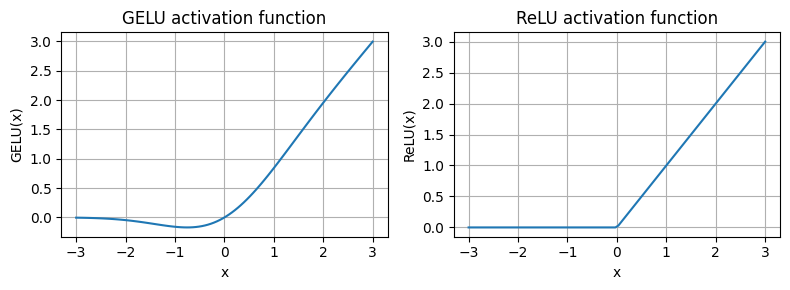

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values

Next, let's implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block later:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Adding Residual / Skip Connections

Shortcut connections were originally proposed in computer vision (ResNet) to mitigate vanishing gradient problems:
* They create an alternative shorter path for the gradient to flow through the network
* This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between



Let us code a simple ResNet

In [ ]:
class SimpleResNet(nn.Module):
    def __init__(self, layer_sizes, use_skipconn):
        super().__init__()
        self.use_skipconn = use_skipconn
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_skipconn and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 3]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(172)
model_without_shortcut = SimpleResNet(
    layer_sizes, use_skipconn=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0004944993415847421
layers.1.0.weight has gradient mean of 0.000599366903770715
layers.2.0.weight has gradient mean of 0.001572751090861857
layers.3.0.weight has gradient mean of 0.0030697041656821966
layers.4.0.weight has gradient mean of 0.004935129079967737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Let us print the gradient values with residual connections:

In [ ]:
torch.manual_seed(seed)
model_with_shortcut = SimpleResNet(
    layer_sizes, use_skipconn=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.17740076780319214
layers.1.0.weight has gradient mean of 0.03897775709629059
layers.2.0.weight has gradient mean of 0.06413140147924423
layers.3.0.weight has gradient mean of 0.06576318293809891
layers.4.0.weight has gradient mean of 0.08002085983753204


Residual connections prevent the gradients from vanishing in the early layers (towards `layer.0`).


## Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

In [ ]:
class MHCausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, block_size, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        # W_query
        self.toqueries = nn.Linear(d_in, d_out, bias=qkv_bias)
        # W_key
        self.tokeys = nn.Linear(d_in, d_out, bias=qkv_bias)
        # W_value
        self.tovalues = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.unifyheads = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        # register_buffer is used for parameters which must be saved and restored in the state_dict, but not trained by the optimizer.
        # Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them.
        self.register_buffer('mask', torch.triu(torch.ones(block_size, block_size), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.tokeys(x) # W_key * x, Shape: (b, num_tokens, d_out)
        queries = self.toqueries(x)
        values = self.tovalues(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2).contiguous()
        queries = queries.transpose(1, 2).contiguous()
        values = values.transpose(1, 2).contiguous()

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        # Original mask truncated to the number of tokens and converted to boolean
        # 1 -> True, 0 -> False
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # Unsqueeze the mask to match dimensions
        mask_unsqueezed = mask_bool.unsqueeze(0)
        # Use the unsqueezed mask to fill attention scores
        # masked_fill_ is a method for torch.tensor. It fills -torch.inf where True
        # -torch.inf allows softmax to apply a good normalization
        attn_scores.masked_fill_(mask_unsqueezed, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.unifyheads(context_vec) # optional projection

        return context_vec

In [ ]:
torch.triu(torch.ones(7, 7), diagonal=1).bool().unsqueeze(0)

tensor([[[False,  True,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True,  True],
         [False, False, False,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True],
         [False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True],
         [False, False, False, False, False, False, False]]])

In [ ]:
#from previous_chapters import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mhcausalattention = MHCausalSelfAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            block_size=cfg["ctx_len"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        skipconn = x
        x = self.norm1(x)
        x = self.mhcausalattention(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + skipconn  # Add the original input back

        # Shortcut connection for feed forward block
        skipconn = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + skipconn  # Add the original input back

        return x

Suppose we have 2 input samples with 4 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size.

In [ ]:
torch.manual_seed(seed)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT-2, finally!

- Let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a useable GPT architecture
- The transformer block is repeated multiple times. For 124M GPT-2 model, we repeat it 12 times:

<center><img src="https://drive.google.com/uc?id=1bDOByqtAZDRVSQU1draJJNR-M8G55e28" width="700"/>
</center>


- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [ ]:
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 7594,   257, 10708,  7815],
        [  270,   422,   627,  2545]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.0556, -0.6321,  0.8928,  ...,  1.3186,  0.9420,  0.0778],
         [-0.2670, -0.5955,  1.3053,  ..., -0.0385,  0.2925, -1.0127],
         [-0.9495,  0.4569,  0.9454,  ...,  0.3255,  0.7190,  0.8770],
         [-0.4878,  0.4239,  0.2960,  ...,  0.6685, -0.7535,  0.0145]],

        [[-0.2281,  0.4241, -0.1646,  ...,  0.4555,  1.5415,  0.0363],
         [ 0.2128,  0.3938,  0.4494,  ..., -0.1624,  0.2563, -0.2195],
         [-0.0963,  0.9541,  0.2157,  ..., -0.4734, -0.2097,  0.0052],
         [-0.4723,  0.8137, -0.0994,  ...,  0.8414, -0.5208, -0.4543]]],
       grad_fn=<UnsafeViewBackward0>)


The model is not trained (not  in this lecture). We can count the number of parameters:


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices: the next chapter
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In practice, it is easier to train the model without weight-tying, which is why we didn't implement it here. Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## Text Generation

- LLMs like the GPT model we implemented above are used to generate one word at a time

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- The figure below depicts how the GPT model, given an input context, generates the next word token

<center><img src="https://drive.google.com/uc?id=1GObNGqyAPinaSnh7zRZimnX4lVBYYL4L" width="700"/>
</center>


In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

The `generate_text_simple` above implements an iterative process, where it creates one token at a time. Let's prepare an input example:



In [ ]:
b = logits[0, -1, :]
b[0] = -1.4929
b[1] = 4.4812
b[2] = -1.6093

print(b[:3])
torch.softmax(b, dim=0)

tensor([-1.4929,  4.4812, -1.6093], grad_fn=<SliceBackward0>)


tensor([3.0882e-06, 1.2140e-03, 2.7489e-06,  ..., 6.3615e-06, 6.2870e-05,
        3.9754e-06], grad_fn=<SoftmaxBackward0>)

In [ ]:
start_context = "Quantum physics might be"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [24915, 388, 11887, 1244, 307]
encoded_tensor.shape: torch.Size([1, 5])


In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["ctx_len"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[24915,   388, 11887,  1244,   307, 49117, 20336, 32556, 22428, 20390,
         48979]])
Output length: 11


Remove batch dimension and convert back into text:

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Quantum physics might be entrants Gutenberg imbalanceacerb UpperEmergency


Note that the model is untrained; hence the random output texts above
